In [1]:
import os
# import mapclassify
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import ipywidgets as widgets
from IPython.display import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime

import geopandas as geo

%matplotlib inline

### Import US Counties Dataset

In [2]:
df = pd.read_csv('../data/output.csv')
print('Rate Max: ' + str(df.loc[:,'Rate'].max()))
print('Rate Min.: ' + str(df.loc[:,'Rate'].min()))
print('Rate Mean: ' + str(df.loc[:,'Rate'].mean()))
print('Rate Std.: ' + str(df.loc[:,'Rate'].std()))   

Rate Max: 58.4
Rate Min.: 0.0
Rate Mean: 6.175009711500675
Rate Std.: 3.112534815614922


In [3]:
df['Date'] = df.apply(lambda x: x.Month+' '+str(x.Year), axis=1)
df.Date = pd.to_datetime(df.Date)

In [4]:
df.drop(columns=['Year', 'Month'], inplace=True)

In [5]:
df.head()

,State,County,Rate,Date
0,Mississippi,Newton County,6.1,2015-02-01
1,Mississippi,Panola County,9.4,2015-02-01
2,Mississippi,Monroe County,7.9,2015-02-01
3,Mississippi,Hinds County,6.1,2015-02-01
4,Mississippi,Kemper County,10.6,2015-02-01


In [6]:
# Clean Data
df['County'] = df.County.str.replace(' County', '')
print(df.head())
print(np.sum(df[['State', 'County']].isin({'County':['Newton'], 'State':['Mississippi']})))

         State  County  Rate       Date
0  Mississippi  Newton   6.1 2015-02-01
1  Mississippi  Panola   9.4 2015-02-01
2  Mississippi  Monroe   7.9 2015-02-01
3  Mississippi   Hinds   6.1 2015-02-01
4  Mississippi  Kemper  10.6 2015-02-01
State     26568
County     1523
dtype: int64


### Election Returns Data by State 1976-2016

In [7]:
# Import & Clean data
df_p = pd.read_csv('../data/1976-2016-president.csv')
df_p = df_p[(df_p.state != 'Alaska') & (df_p.state != 'Hawaii')]
df_p.insert(loc=5, column='vote_p', value=df_p.candidatevotes.divide(df_p['totalvotes'], axis=0), allow_duplicates=True)
df_p.drop(columns=['state_fips', 'office', 'state_ic', 'state_cen', 'writein', 'version', 'notes', 'candidatevotes', \
                   'totalvotes', 'candidate', 'state_po'], inplace=True)
df_p.head()

,year,state,vote_p,party
0,1976,Alabama,0.557273,democrat
1,1976,Alabama,0.426149,republican
2,1976,Alabama,0.007776,american independent party
3,1976,Alabama,0.005638,prohibition
4,1976,Alabama,0.001652,communist party use


In [8]:
# Get labels for each state by year

idx = df_p.groupby(['state', 'year'], sort=False)['vote_p'].transform(max) == df_p['vote_p']
df_p = df_p[idx].reset_index(drop=True)

# Reset Party to more simple string
df_p.party.where(df_p.party == 'democrat', 'R', True)
df_p.party.where(df_p.party == 'R', 'D', True)

df_p.drop(columns='vote_p', inplace=True)

# Filter years from what's in dataset
df_p = df_p[df_p.year >= 1988]

# Unique Values
states = np.unique(df_p.state)
# print(states)
years = np.unique(df_p.year)
print(years)

print(df_p.head())

[1988 1992 1996 2000 2004 2008 2012 2016]
     year       state party
147  1988     Alabama     R
148  1988     Arizona     R
149  1988    Arkansas     R
150  1988  California     R
151  1988    Colorado     R


In [9]:
df_t = pd.DataFrame(index=years, columns=states)
df_t.head()

,Alabama,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Transpose matrix to have indices as year with columns as state
for year in years:
    df_t.loc[year,:] = df_p[df_p.year == int(year)].sort_values(by='state')['party'].T.to_numpy()
df_t.head()

,Alabama,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
1988,R,R,R,R,R,R,R,D,R,R,...,R,R,R,R,R,R,D,D,D,R
1992,R,R,D,D,D,D,D,D,R,D,...,R,D,R,R,D,R,D,D,D,R
1996,R,D,D,D,R,D,D,D,D,R,...,R,D,R,R,D,R,D,D,D,R
2000,R,R,R,D,R,D,D,D,R,R,...,R,R,R,R,D,R,D,R,D,R
2004,R,R,R,D,R,D,D,D,R,R,...,R,R,R,R,D,R,D,R,D,R


### President Terms

In [11]:
pres = pd.read_csv('../data/presidents.csv')
pres.drop(columns=['Presidency ', 'Wikipedia Entry', 'Portrait', 'Thumbnail', 'Home State'], inplace=True)
pres.loc[44] = ['Donald Trump', '20/01/2017', '20/01/2020', 'Republican']
pres.rename(columns={"President ":"President","Took office ":"Start", "Left office ":"End", "Party ": "Party"}, inplace=True)
pres.loc[43,'End'] = '20/01/2017'

# Drop dates < 1990
pres = pres[40:44]
pres.tail()

,President,Start,End,Party
40,George H. W. Bush,20/01/1989,20/01/1993,Republican
41,Bill Clinton,20/01/1993,20/01/2001,Democratic
42,George W. Bush,20/01/2001,20/01/2009,Republican
43,Barack Obama,20/01/2009,20/01/2017,Democratic


In [12]:
# Convert to datetime
pres.Start = pd.to_datetime(pres.Start, format='%d/%m/%Y')
pres.Start = pres.Start.dt.strftime("%Y-%m-%d")

pres.End = pd.to_datetime(pres.End, format='%d/%m/%Y')
pres.End = pres.End.dt.strftime("%Y-%m-%d")

In [13]:
pres.Party.replace(" ", "")
pres.Party.where(pres.Party.str.contains('Democratic'), 'R', True)
pres.Party.where(pres.Party.str.contains('R'), 'D', True)

pres.tail()

,President,Start,End,Party
40,George H. W. Bush,1989-01-20,1993-01-20,R
41,Bill Clinton,1993-01-20,2001-01-20,D
42,George W. Bush,2001-01-20,2009-01-20,R
43,Barack Obama,2009-01-20,2017-01-20,D


In [14]:
def highlight_plot(ax, alpha=0.4):
    for index, row in pres.iterrows():
        if row['Party'] == 'D':
            ax.axvspan(row['Start'], row['End'], facecolor='blue', alpha=alpha, label=row['President'])
        else:
            ax.axvspan(row['Start'], row['End'], facecolor='red', alpha=alpha, label=row['President'])

In [15]:
def plot_df(df, legend=True, highlight=True, alpha=0.7, ylbl ='Unemployment Rate', xlbl = 'Year', dest='', title=''):
    # Plot figure
    fig, ax = plt.subplots(figsize=[10, 6])
    plt.tight_layout()
    ax.plot(df['Rate'])

    # Plot the vertical bars
    if highlight:
        highlight_plot(ax)

    # Additional Plot settings
    if legend:
        ax.legend()
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.title(title)
    plt.ylabel(ylbl)
    plt.xlabel(xlbl)
    if len(dest) > 0:
        plt.savefig('../Images/%s%s'%(dest, 'png'))

In [16]:
# More New York
df_ny = df[df.State =='New York']
df_ny = df_ny.reset_index().set_index('Date').drop(['index'], axis=1)
df_ny = df_ny.sort_values('Date')

df_ny.head()

,State,County,Rate
Date,,,
1990-01-01,New York,Wyoming,8.0
1990-01-01,New York,Chenango,6.5
1990-01-01,New York,Westchester,3.5
1990-01-01,New York,Otsego,6.8
1990-01-01,New York,New York,6.6


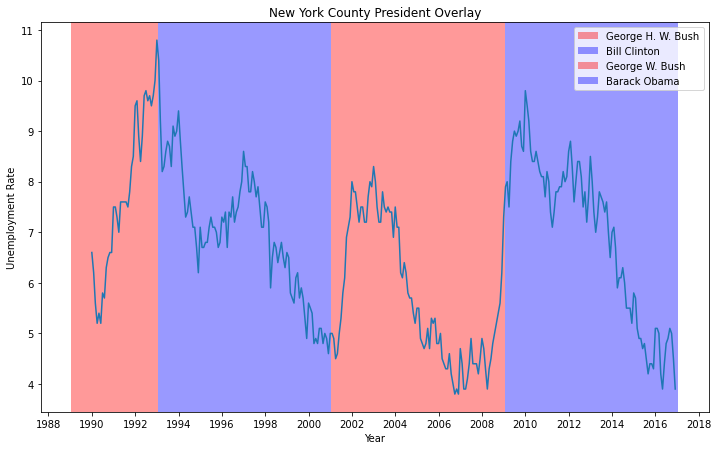

In [17]:
# Plot figure
plot_df(df_ny[df_ny.County=='New York'], title='New York County President Overlay')